In [1]:
'''
Naive bayes con feature selection specifica per ogni classe, per ogni classe facciamo
l'estrazione delle features con la tecnica del chi2 e fittiamo i modelli
su ogni classe separatamente 
'''

import time
import codecs
import csv
#import argparse
import os
import numpy as np
import pandas as pd
import pickle

#from dill import dill
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
#from sklearn import cross_validation, svm
from sklearn.svm import LinearSVC
#from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#from sklearn.tree.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from nltk.corpus import stopwords
from nltk.stem.snowball import ItalianStemmer
from nltk.tokenize import word_tokenize


# modulo per confrontare il risultato delle regex
# richiede entrambi i db già etichettati
import tortellino_parmigiano 
import crea_db


import evaluation_report # stampa confusion_matrix e altro
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
ita_stopwords = set(stopwords.words('italian'))
ita_stemmer = ItalianStemmer()
ita_stemming = ita_stemmer.stem
def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
    doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
    #doc = map(ita_stemming, doc)
    #doc = [ita_stemmer.stem(a) for a in doc]
    #temp = ''
    #for par in doc:
    #    temp = '{} {}'.format(temp, ita_stemming(par))        
    return list(doc)

class CestinoTraining:
    def __init__(self, features, labels, categories):
        self.stemmed = list(map(get_tokenizer, texts))
        self.features = features
        self.labels = np.array(labels)
        self.categories = categories

DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI
# ci assicuriamo siano presenti i DB
training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) ################################

    
if os.path.exists('/home/backup/dati_e_csv/training_stemmed-bubu.pickle'):
    print('Trovato salvataggio training set')
    with open('/home/backup/dati_e_csv/training_stemmed-bubu.pickle', 'rb') as file:
        salvataggio = pickle.load(file)
    texts = salvataggio.features
    stemmed_train = salvataggio.stemmed
    Y = salvataggio.labels
    etichette = ['attivazione', 'canone rai', 'cessazione', 'contratto', 'credito',
                 'domiciliazione', 'fatturazione', 'gr-invito a chiamare - focus', 'non di competenza', 'richiamate']
    print('Salvataggio caricato')
else:
    print('Creo il training set')
    
    texts = list()
    labels = list()
    names= []

    # load training dataset # possiamo usare sqlite
    with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
        reader = csv.reader(file, delimiter=';')
        etichette = next(reader)
        for row in reader:
            # load documents
            #print('Nome {}, etichette {}, conversazione{}'.format(row[10], row[:10], row[11]+row[12]))
            #raise SystemExit
            unito = (row[11]+row[12]).replace('#O:', '').replace('#C:', '') #concatena il testo cliente con operatore
            texts.append(unito)
            # load row name
            names.append(row[10])
            # load labels
            labels.append(list(map(lambda x: int(x), row[:10])))

    print('dimensioni:',len(texts), len(labels))
    # tokenization function # possiamo usare anche solo un canale cliente/operatore
    print('Inizio lo stemming')

    salvataggio = CestinoTraining(texts, labels, etichette)
    stemmed_train = salvataggio.stemmed
    Y = salvataggio.labels
    with open('/home/backup/dati_e_csv/training_stemmed-bubu.pickle', 'wb') as file:
        pickle.dump(salvataggio, file, protocol=0)
    print('Training set creato e salvato')

# ------------------------------------

# DATA_FOLDER = "/home/backup/dati_e_csv/" # DATI


# # ci assicuriamo siano presenti i DB
# training_db_name = crea_db.build_training(OUTPUT=DATA_FOLDER)
# test_db_name = crea_db.build_test(OUTPUT=DATA_FOLDER) 

# texts = list()
# labels = list()
# names= []
# names_and_text = []

# # load training dataset # possiamo usare sqlite
# start_time = time.time()
# with codecs.open(os.path.join(DATA_FOLDER, training_db_name), 'r', errors='ignore') as file:
#     reader = csv.reader(file, delimiter=';')
#     etichette = next(reader)
#     for row in reader:
#         # load documents
#         #print('Nome {}, etichette {}, conversazione{}'.format(row[10], row[:10], row[11]+row[12]))
#         #raise SystemExit
#         unito = row[11]+row[12].replace('#O:', '').replace('#C:', '') #concatena il testo cliente con operatore
#         texts.append(unito) 
#         # load row name
#         names.append(row[10])
#         # load labels
#         labels.append(list(map(lambda x: int(x), row[:10])))
#         names_and_text.append(tuple([row[10]]) + tuple([unito]) + tuple([row[:10]]))
# Y = np.array(labels)
# print(len(texts), len(labels))
# # tokenization function # possiamo usare anche solo un canale cliente/operatore

# ita_stopwords = set(stopwords.words('italian'))
# ita_stemmer = ItalianStemmer()
# ita_stemming = ita_stemmer.stem

# def get_tokenizer(doc): #(word_ngrams=None, char_ngrams=None, stopwords=None, additional_extractors=None):
#     doc = filter(lambda x: x not in ita_stopwords, word_tokenize(doc))
#     #doc = map(ita_stemming, doc)
#     #doc = [ita_stemmer.stem(a) for a in doc]
#     temp = ''
#     for par in doc:
#         temp = '{} {}'.format(temp, ita_stemming(par))
#     return temp

# stemmed_train = list(map(get_tokenizer, texts))
#print('Stemmati in -- %s seconds ----!'% (time.time() - start_time))


Training sqlite e csv presenti!
Carico training_regex.csv
Test sqlite e csv presenti!
Carico test_manina
Trovato salvataggio training set
Salvataggio caricato


In [15]:
ita_stopwords = set(stopwords.words('italian'))
doc = []
doc = filter(lambda x: x not in ita_stopwords, word_tokenize(texts[1]))


['sì', 'inviato', 'documentazioni', 'fonte', 'signora', 'numero', 'cliente', 'vediamo', 'signora', 'numero', 'cliente', 'senza', 'essere', 'persone', 'ministro', 'toccata', 'allora', 'documentazione', 'inviato', 'risultava', 'barche', 'correttamente', 'compilata', 'marcato', 'Castelli', 'fiscale', 'delicata', 'molto', 'estremo', 'ce', "'", 'ancora', 'signora', 'anzi', 'serve', 'venticinque', 'agosto', 'allora', 'no', 'signora', 'lì', 'fronte', 'stare', 'domani', 'pomeriggio', 'tasti', 'documenti', 'lender', 'lavorasse', 'giro', 'quarantotto', 'ore', 'quindi', 'vedete', 'ricontattare', 'domani', 'verso', 'tardi', 'vedere', 'pervenuti', 'documenti', 'va', 'bene', 'ce', "'", 'ancora', "c'è", 'ancora', 'tutta', 'no', 'nono', 'bis', 'signora', "c'è", 'proprio', 'so', 'signora', 'vedo', 'grazie', 'buongiorno', "c'è", 'concorrenza', 'meno', 'fare', 'pratica', 'po', "'", 'giorni', 'aspetto', 'sì', 'presa', 'fatto', 'mandato', 'fax', 'compilato', 'po', "'", 'Como', 'ottenendo', 'Torino', 'numer

In [4]:
# Build data matrix for training set: stemmed,stopword
print('building DT matrix...')
start_time = time.time()
count_vect = CountVectorizer()#analyzer=get_tokenizer, max_df=0.6, min_df=0.001)
X_train_counts = count_vect.fit_transform(texts)
#tf_transformer = TfidfTransformer(use_idf=True)
#X_train_counts = tf_transformer.fit_transform(X_train_counts)
print('DT matrix ceated in -- {}s ---.shape: {}, {}'.format(
        time.time() - start_time, X_train_counts.shape[0],X_train_counts.shape[1]))


building DT matrix...
DT matrix ceated in -- 6.613051891326904s ---.shape: 20706, 59598


In [8]:
X_train_counts[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [4]:
# features selection
inverse_vocab = { v:k for k,v in count_vect.vocabulary_.items()} 

print('features selection with chi2...')
chi_k = []
chi_features = []
texts = []
#k = int(X_train_counts.shape[1] * 0.10)
k = (4000,1500,2500,5000,2500,2500,1500,3000,3000,5000)
scores = []
feat = []
for i in range(Y.shape[1]):
    feat.append(SelectKBest(chi2, k=k[i]))
    texts.append(feat[i].fit_transform(X_train_counts,Y[:,i])) # fitto tanti modelli quante classi, per ogni classe faccio la feature selection
    scores.append(feat[i].pvalues_)
    chi_k.append(feat[i].get_support(indices=True))
    chi_features.append(texts[i])
print('ok')

# learn models for each categoriy
chi_models = []
for i in range(Y.shape[1]):
    #clf = OneVsRestClassifier(MultinomialNB(), n_jobs=2)
    class_proba = np.sum(Y[:,i])/Y.shape[0]
    print('class probability {:<20}: {:.3g}%'.format(etichette[i], class_proba*100))
    chi_models.append(MultinomialNB())
    # many models for many classes
    chi_models[i].fit(chi_features[i], Y[:,i])
print('\nmodelli creati')

features selection with chi2...
ok
class probability attivazione         : 9.56%
class probability canone rai          : 3.93%
class probability cessazione          : 2.19%
class probability contratto           : 14.9%
class probability credito             : 49.8%
class probability domiciliazione      : 3.39%
class probability fatturazione        : 20%
class probability gr-invito a chiamare - focus: 46.3%
class probability non di competenza   : 3.36%
class probability richiamate          : 10.3%

modelli creati


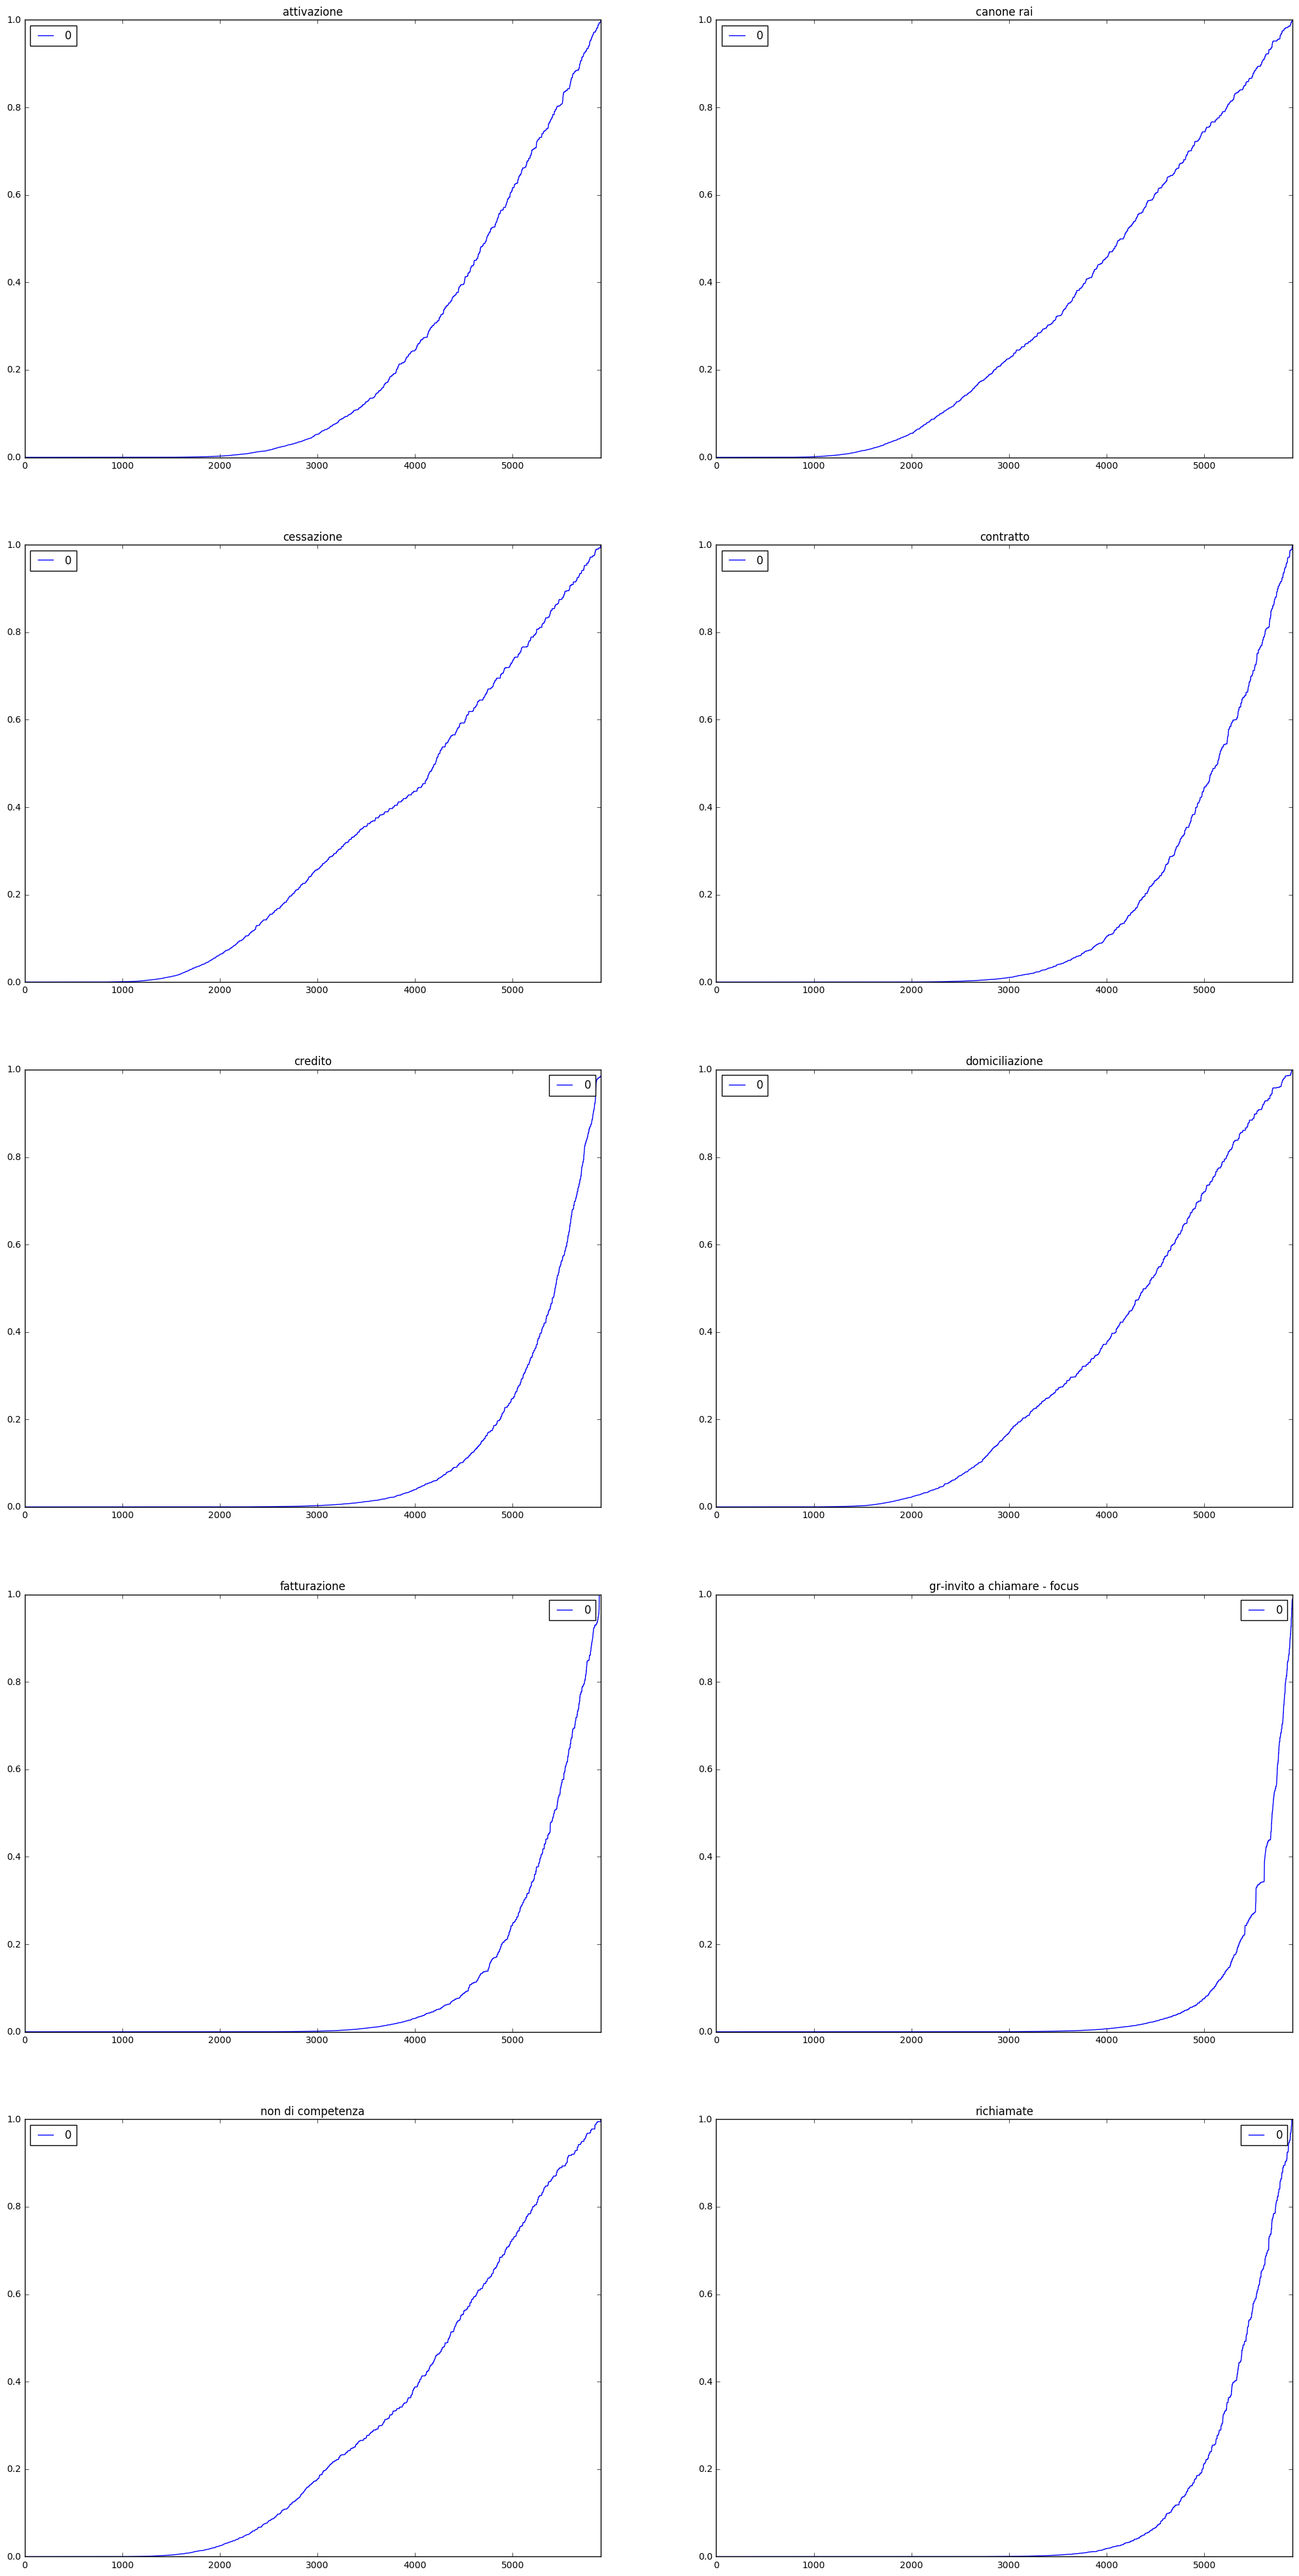

In [30]:
# PLOT p-values 

import matplotlib.pyplot as plt 
%matplotlib inline 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25,50))

import pandas as pd
#pd_scores = pd.DataFrame(scores[0])
#pd_scores.head()
#pd_inverse_vocab = pd.DataFrame.from_dict(inverse_vocab, orient='index')
#pd_inverse_vocab
#pd_scores[1] = pd_inverse_vocab[0]
#pd_scores = pd_scores.sort_values(by=0, ascending=1)
#pd_scores
#print(pd_scores.head())


#pd_scores[pd_scores[0] < 1e-2].dropna()
for i in range(Y.shape[1]):
    pd_scores = pd.DataFrame(scores[i])
    pd_scores = pd_scores.sort_values(by=0, ascending=1)
    if i % 2 == 0:
        pd_scores.plot(use_index=False, ax=axes[int(i/2), 0]).set_title(etichette[i])
    else:
        pd_scores.plot(use_index=False, ax=axes[int(i/2), 1]).set_title(etichette[i])
    
plt.show()

In [8]:
# esploro le feature selezionate dando un occhio ai p-values
l, m = list(), list()
for i,k in enumerate(chi_k[1]):
    #print('{} {}'.format(inverse_vocab[k], scores[1][i]))
    l.append(inverse_vocab[k])
    m.append(scores[1][i])

print(scores[1].mean(), np.median(scores[1]), scores[1].min(), scores[1].max())

0.316951729872 0.218616729973 0.0 0.999677199027


In [9]:
# print the most correlated words in canone-rai
pval_pd = pd.Series(m, index=l)
pval_pd.sort_values(ascending=True).head(20)

centose       0.000000e+00
ordin         0.000000e+00
medic         0.000000e+00
attribu       0.000000e+00
dopodoman    1.475844e-270
pension      2.569406e-237
megl         4.851566e-194
orar         2.432223e-153
enel         1.002488e-133
dopodic      2.939204e-133
canal        4.753569e-124
carit        2.295865e-111
poverin      9.166893e-108
ossol        3.005785e-107
automat      3.358128e-107
mant         9.423134e-105
fatic        2.765531e-104
tort          7.149087e-83
tolt          3.932670e-82
canad         2.955933e-77
dtype: float64

In [10]:
# importo e trasformo il test set annotato a mano
unito_test = []
names_test = []
test_texts = list()
y_true_ammano = list()

# load test data
# carica il test set
with codecs.open(os.path.join(DATA_FOLDER, test_db_name), 'r', errors='ignore') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)
    print(etichette)
    for row in reader:
        # load documents
        test_texts.append((row[1]+row[2]).replace('O:', '').replace('C:', ''))
        # load names
        names_test.append(row[0])
        # load labels
        y_true_ammano.append(list(map(lambda x: int(x),row[-10:])))
        
stemmed_test = list(map(get_tokenizer, test_texts))
print('\ntest set caricato')

# test set vectorization
test_ammano = count_vect.transform(stemmed_test)
print('\nTest set vettorizzato. pronti')

# prendo dal training solo i documenti che sono nel test_set
# subset_X_train = []
# y_true_train = []
# for name,text,label in names_and_text:
#     if name in names_test:
#         subset_X_train.append(text)
#         y_true_train.append(label)

# stemmed_subset_train = list(map(get_tokenizer, subset_X_train))
# subset_X_train_DTM = count_vect.transform(stemmed_subset_train)

['attivazione', 'canone rai', 'cessazione', 'contratto', 'credito', 'domiciliazione', 'fatturazione', 'gr-invito a chiamare - focus', 'non di competenza', 'richiamate']

test set caricato

Test set vettorizzato. pronti


In [11]:
# valuto il modello con il chi2   ---  
test_feat = []
test_DT = count_vect.transform(stemmed_test)
# feature selection sul test set
for i in range(Y.shape[1]):
    test_feat.append(feat[i].transform(test_DT))
    
# predictions    
chi_true_y = np.array(y_true_ammano)
chi_predicted = np.zeros(shape=(len(test_texts), Y.shape[1]))
for i in range(Y.shape[1]):
    # apply model to data
    chi_predicted[:,i] = chi_models[i].predict(test_feat[i]) 

# report
print(classification_report(chi_true_y, chi_predicted, target_names=etichette))

print('\n','INDICI: \n')
print('accuracy', accuracy_score(chi_true_y, chi_predicted))
print('precision micro',precision_score(chi_true_y, chi_predicted, average='micro') )
print('recall micro',recall_score(chi_true_y, chi_predicted, average='micro'))
print('f1 micro', f1_score(chi_true_y, chi_predicted, average='micro'))
print('precision macro', precision_score(chi_true_y, chi_predicted, average='macro') )
print('recall macro', recall_score(chi_true_y, chi_predicted, average='macro'))
print('f1 macro', f1_score(chi_true_y, chi_predicted, average='macro'))

# print error rate for each category
print('\n ERROR RATES\n')
for cat in range(Y.shape[1]):
    print('error-rate for %s: ' % etichette[cat], 1 - accuracy_score(chi_true_y[:,cat], chi_predicted[:,cat]))


                              precision    recall  f1-score   support

                 attivazione       0.59      0.79      0.67        73
                  canone rai       0.78      0.51      0.62        63
                  cessazione       0.12      0.30      0.17        10
                   contratto       0.50      0.70      0.58        74
                     credito       0.61      0.87      0.72       162
              domiciliazione       0.27      0.76      0.40        21
                fatturazione       0.48      0.41      0.44       124
gr-invito a chiamare - focus       0.08      0.74      0.15        23
           non di competenza       0.56      0.30      0.39        50
                  richiamate       0.03      0.67      0.05         3

                 avg / total       0.54      0.64      0.56       603


 INDICI: 

accuracy 0.122641509434
precision micro 0.398969072165
recall micro 0.641791044776
f1 micro 0.492053401144
precision macro 0.400461065841
recall 

In [13]:
from sklearn.ensemble import BaggingClassifier

bag_models = []
for i in range(Y.shape[1]):
    #clf = OneVsRestClassifier(MultinomialNB(), n_jobs=2)
    class_proba = np.sum(Y[:,i])/Y.shape[0]
    print('class probability {:<20}: {:.3g}%'.format(etichette[i], class_proba*100))
    bag_models.append(BaggingClassifier(MultinomialNB()))
    # many models for many classes
    bag_models[i].fit(chi_features[i], Y[:,i])
print('\nmodelli creati')

# valuto il modello con il chi2   ---  
test_feat = []
test_DT = count_vect.transform(stemmed_test)
# feature selection sul test set
for i in range(Y.shape[1]):
    test_feat.append(feat[i].transform(test_DT))
    
# predictions    
chi_true_y = np.array(y_true_ammano)
bag_predicted = np.zeros(shape=(len(test_texts), Y.shape[1]))
for i in range(Y.shape[1]):
    # apply model to data
    bag_predicted[:,i] = bag_models[i].predict(test_feat[i]) 

# report
print(classification_report(chi_true_y, bag_predicted, target_names=etichette))


SyntaxError: invalid syntax (<ipython-input-13-87c0df8f4856>, line 8)